In [1]:
from Run import Run
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# A more careful selection of events with hodoscope in its rotated position:
# demand good TOF 0 and 1, and signal in T2 (smaller) - remove events with second pulses in first 100 time bins
# TOF between 0 and 1:
trig_diff_window = [7.0,8.5]  # run 635
t2_diff_window = [45.,65.] # run 635
act_min = 5. # run 635
# demand ACT 0 and 1 signals indicating electron
# demand no signal in ACT 3 indicating no charged particle entering
# use fixed integration window for pb-glass

folder = "C:/Users/Karlen/Documents/temp/"

run_baseline = Run.open_file(folder+"run_000676.dk")
baseline_means = run_baseline.user['baseline_means']
baseline_stds = run_baseline.user['baseline_stds']

run_number = 635

run = Run.open_file(folder+"run_000"+str(run_number)+".dk")
config = run.config

if 'signal_times' in run.user:
    signal_times = run.user['signal_times']
else:
    signal_times = None

hodo_ch = {}
for hodo in range(15):
    if hodo < 8:
        hodo_ch[hodo] = 24 + hodo
    else:
        hodo_ch[hodo] = 9 + hodo

voltage_scale = config["VoltageScale"]

In [3]:
# trigger scintillator 0,1,2
triggers = [[8,9,10,11],[12,13,14,15],[6]]
triggers_no_signal = [[0,0,0,0],[0,0,0,0],[0]]
triggers_extra_signal = [[0,0,0,0],[0,0,0,0],[0]]
signal_time_max = 100

trigger_goods = []
trigger_times = []
trigger_diffs_goods = []

for ie in range(len(signal_times[0])):
    trigger_time = []
    trigger_good = True
    for it, trigger in enumerate(triggers):
        trigger_time_sum = 0.
        for ic, channel in enumerate(trigger):
            has_signal = False
            extra_signal = False
            for signal_time in signal_times[channel][ie]:
                if signal_time < signal_time_max and not has_signal:
                    has_signal = True
                    trigger_time_sum += signal_time
                elif signal_time < signal_time_max and has_signal:
                    extra_signal = True
            if not has_signal:
                triggers_no_signal[it][ic] += 1
            if extra_signal:
                triggers_extra_signal[it][ic] += 1
            if not has_signal or extra_signal:
                trigger_good = False
        trigger_time.append(trigger_time_sum/len(trigger))
    trigger_goods.append(trigger_good)
    trigger_times.append(trigger_time)

    trigger_diffs_good = False
    if trigger_good:
        if trig_diff_window[0] < trigger_time[1]-trigger_time[0] < trig_diff_window[1]:
            if t2_diff_window[0] < trigger_time[2]-trigger_time[0] < t2_diff_window[1]:
                trigger_diffs_good = True
    trigger_diffs_goods.append(trigger_diffs_good)

In [26]:
# ACT0 and 1 have signals?
act01_window = [50,100]

act0gain = 10.
acts = [[0,1],[2,3],[4,5]]
act_channel_signals = []
act_goods = []
for ie in range(len(signal_times[0])):
    act_channel_signal = []
    for ia, act in enumerate(acts):
        gain = 1.
        if ia == 0:
            gain = act0gain
        channel_sums = []
        for channel in act:
            act_waveform = run.analyses[channel].raw_waveforms[ie]
            channel_sum = 0
            for it in range(act01_window[0],act01_window[1]):
                channel_sum += act_waveform[it] - baseline_means[channel]
            channel_sums.append(-1.*channel_sum*voltage_scale/gain)
        act_channel_signal.append(channel_sums)
    act_channel_signals.append(act_channel_signal)

    signal_sums = []
    for ia in range(3):
        signal_sum = 0.
        for ic in range(2):
            signal_sum += act_channel_signals[ie][ia][ic]
        signal_sums.append(signal_sum)
    act_good = (signal_sums[0] + signal_sums[1]) > act_min and signal_sums[2] < act_min
    act_goods.append(act_good)


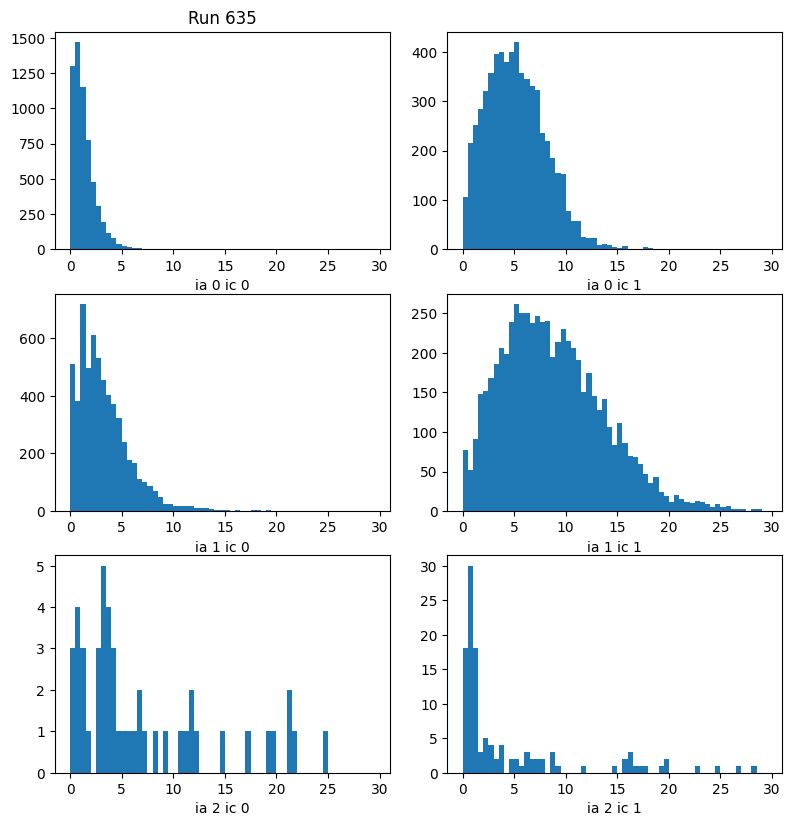

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(8,8))
fig.tight_layout()

axes[0][0].set_title('Run '+str(run_number))
for ia in range(3):
    for ic in range(2):
        signals = []
        for i in range(len(act_channel_signals)):
            if trigger_diffs_goods[i]:
                signals.append(act_channel_signals[i][ia][ic])
        axes[ia][ic].hist(signals,bins=np.arange(0.,30.,0.5))
        axes[ia][ic].set_xlabel('ia '+str(ia)+' ic '+str(ic))

plt.show()

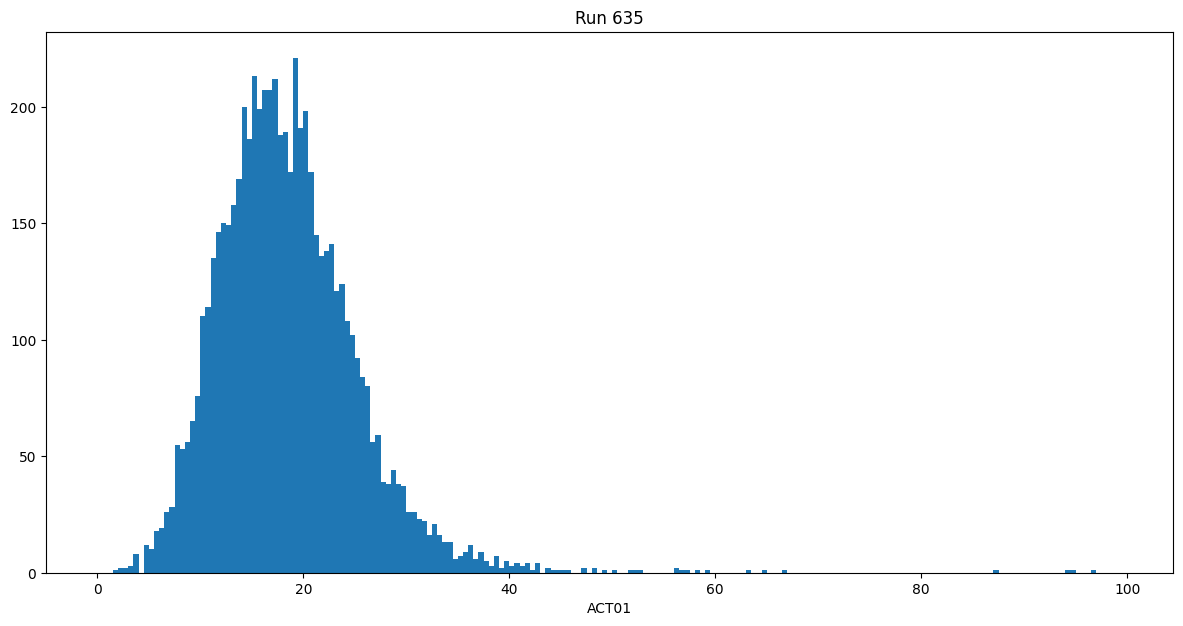

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
fig.tight_layout()

axes.set_title('Run '+str(run_number))
signal_sums = []
for i in range(len(act_channel_signals)):
    if trigger_diffs_goods[i]:
        signal_sum = 0.
        for ia in range(2):
            for ic in range(2):
                signal_sum += act_channel_signals[i][ia][ic]
        signal_sums.append(signal_sum)

axes.hist(signal_sums,bins=np.arange(0.,100.,0.5))
axes.set_xlabel('ACT01')

plt.show()

In [23]:
trigger_diffs = []
for ie,trigger_time in enumerate(trigger_times):
    if trigger_goods[ie]:
        delta = trigger_time[2]-trigger_time[0]
        #if 7 <delta < 8.2:
        trigger_diffs.append(delta)

In [19]:
triggers_no_signal,triggers_extra_signal

([[0, 0, 0, 0], [19, 21, 20, 18], [0]],
 [[956, 722, 839, 723], [288, 1184, 651, 1766], [4]])

In [24]:
len(trigger_diffs)

6261

In [25]:
np.mean(trigger_diffs)

53.06441897135424

In [26]:
np.std(trigger_diffs)

3.094145692187462

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,  38., 150., 191., 189., 202., 201., 178., 215., 234.,
        305., 373., 418., 380., 408., 375., 369., 374., 222., 213., 239.,
        196., 182., 171., 206., 146.,  71.,   7.,   0.,   3.,   1.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.]),
 array([40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. ,
        45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5, 50. , 50.5,
        51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. , 55.5, 56. ,
        56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5, 61. , 61.5,
        62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5, 66. , 66.5, 67. ,
        67.5, 68. , 68.5, 69. , 69.5]),
 <BarContainer object of 59 artists>)

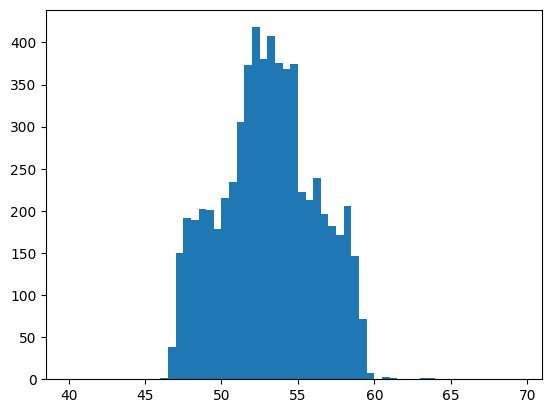

In [28]:
plt.hist(trigger_diffs,bins=np.arange(40.0,70,0.5))